# Driving Towards a Brighter Future: EV Adaption Rates in California and its Effect on PM 2.5 Emissions



This notebook is aimed at the exploratory data analysis for the growing presence of electric vehicles in California and its relationship with PM2.5 Emissions.

It consists of importing several datasets, cleaning and manipulating the data, merging the datasets together, and finally creating several visuals to help interpret the data. 

### Contributions: 
-  __Clarissa Clark__ - Data Import, Cleaning, and Merging (PM 2.5; Population Data)
- __Lucas Keller__ - Merged Visualizations (Heat Map, Correlation Plots, PM2.5 per Counties)
- __Brett Schmidt__ - Data Import, Cleaning, Vehicle Visualizations (California Vehicle)
#### SIADS 593 Milestone I -  October 7th, 2024

# Imports and Requirements

In [1]:
#uncomment to install openpyxl if required to import excel
#pip install openpyxl
#!pip install -r requirements.txt

In [53]:
## import required libraries
import pandas as pd
import numpy as np
from scipy.stats import zscore
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# California Vehicles - Import, Clean, and Visualization
Data sourced from https://www.energy.ca.gov/files/zev-and-infrastructure-stats-data and downloads as "Vehicle_Population_Last_updated_04-30-2024_ada.xlsx".

The dataset contains information on California vehicles, which includes registration year, county, make, model, fuel type, and total vehicles under those categories. 

The goal for this section is to import the data, remove unnecessary information, check for missing or unexpected values, and provide a dataframe to later merge on 'County' and 'Year'.

#### Import Data
Data is provided, but can be imported directly from the URL.

In [3]:
## File has been predownloaded and is part of the analysis package ##
vehicle_data = 'vehicle_data/california_vehicle.xlsx'

## Switch url_import if direct download is desired ##
url_import = False
if url_import:
    if not os.path.exists(vehicle_data_dir):
        os.makedirs(vehicle_data_dir)
    URL = 'https://www.energy.ca.gov/filebrowser/download/6311?fid=6311#block-symsoft-page-title'
    urlretrieve(URL, vehicle_data)

In [4]:
## Import data as a pandas dataframe ##
countyvehicle_df = pd.read_excel('vehicle_data/california_vehicle.xlsx',sheet_name="County")

#### Inspect and Reduce Data
We'll take a look at the shape, contents, and check for unnecessary columns.

In [5]:
## We've isolated the worksheet, now let's take a look at the shape ##
countyvehicle_df.shape

(33542, 7)

We see there are 33542 rows and 7 columns, now let's see what is inside.

In [6]:
countyvehicle_df.head()

,Data Year,County,Dashboard Fuel Type Group,Fuel Type,Make,Model,Number of Vehicles
0,2010,Alameda,Battery Electric (BEV),Battery Electric (BEV),Ford,Ranger,3
1,2010,Alameda,Battery Electric (BEV),Battery Electric (BEV),Tesla,Roadster,17
2,2010,Alameda,Diesel,Diesel,NaN,NaN,10939
3,2010,Alameda,Gasoline,Flex Fuel,NaN,NaN,10974
4,2010,Alameda,Gasoline,Gasoline,NaN,NaN,840577


We're not interested in the Make or Model of the car, so let's drop those values and inspect the information of our dataframe.

In [7]:
countyvehicle_df = countyvehicle_df.drop(columns=['Make','Model'])
countyvehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33542 entries, 0 to 33541
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Data Year                  33542 non-null  int64 
 1   County                     33542 non-null  object
 2   Dashboard Fuel Type Group  33542 non-null  object
 3   Fuel Type                  33542 non-null  object
 4   Number of Vehicles         33542 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.3+ MB


There are __33542__ counts across each entry. That's good.

Now let's check for missing years and missing counties.

In [8]:
years = [year for year in countyvehicle_df['Data Year'].unique()]
actual_years = set(years)

expected_years = set(range(min(years), max(years) + 1))
missing_years = expected_years - actual_years

print(years)
print(f'\nData starts in {min(years)} and spans across {max(years)}')

if missing_years:
    print(f"Missing years: {missing_years}")
else:
    print("No missing years.")

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

Data starts in 2010 and spans across 2023
No missing years.


In [9]:
counties = [county for county in countyvehicle_df['County'].unique()]
actual_counties = set(counties)
expected_counties = set([
    "Alameda", "Alpine", "Amador", "Butte", "Calaveras", "Colusa",
    "Contra Costa", "Del Norte", "El Dorado", "Fresno", "Glenn",
    "Humboldt", "Imperial", "Inyo", "Kern", "Kings", "Lake",
    "Lassen", "Los Angeles", "Madera", "Marin", "Mariposa",
    "Mendocino", "Merced", "Modoc", "Mono", "Monterey", "Napa",
    "Nevada", "Orange", "Placer", "Plumas", "Riverside",
    "Sacramento", "San Benito", "San Bernardino", "San Diego",
    "San Francisco", "San Joaquin", "San Luis Obispo", "San Mateo",
    "Santa Barbara", "Santa Clara", "Santa Cruz", "Shasta",
    "Sierra", "Siskiyou", "Solano", "Sonoma", "Stanislaus",
    "Sutter", "Tehama", "Trinity", "Tulare", "Tuolumne",
    "Ventura", "Yolo", "Yuba"
])
missing_counties = expected_counties - actual_counties

unexpected_counties = actual_counties - expected_counties

if missing_counties:
    print(f"Missing counties: {missing_counties}")
else:
    print("No missing counties.")

if unexpected_counties:
    print(f"Unexpected counties: {unexpected_counties}")
else:
    print("No unexpected counties.")

No missing counties.
Unexpected counties: {'Out Of State', 'Out of State'}


There are unexpected counties that are from out of state.

Let's see what years have vehicles from out of state and how many there are.

We'll only look at the past 10 years for this analysis, but can be adjusted based on lookbackyears.

In [10]:
vehicles_by_year = countyvehicle_df.groupby('Data Year')['Number of Vehicles'].sum()
lookbackyears = 10
for year in countyvehicle_df['Data Year'].unique()[-lookbackyears:]:
    for unexpected_county in unexpected_counties:
        unexpected_vehicles = countyvehicle_df[(countyvehicle_df['Data Year'] == year) & 
                                             (countyvehicle_df['County'] == unexpected_county)]

        total_unexpected_vehicles_by_year = unexpected_vehicles['Number of Vehicles'].sum()
        
        if total_unexpected_vehicles_by_year!= 0:
            total_vehicles = vehicles_by_year.get(year, 0)
            ratio = total_unexpected_vehicles_by_year/total_vehicles*100
            #print(unexpected_county)
            #print(total_unexpected_vehicles_by_year_list)
            print(f"Percent of vechicles from '{unexpected_county}' in {year} is: {ratio:.2f}%")

Percent of vechicles from 'Out Of State' in 2014 is: 2.13%
Percent of vechicles from 'Out Of State' in 2015 is: 2.11%
Percent of vechicles from 'Out Of State' in 2016 is: 1.64%
Percent of vechicles from 'Out Of State' in 2017 is: 1.58%
Percent of vechicles from 'Out Of State' in 2018 is: 1.51%
Percent of vechicles from 'Out Of State' in 2019 is: 1.69%
Percent of vechicles from 'Out Of State' in 2020 is: 1.55%
Percent of vechicles from 'Out of State' in 2021 is: 1.35%
Percent of vechicles from 'Out of State' in 2022 is: 1.40%
Percent of vechicles from 'Out Of State' in 2023 is: 1.37%


Looks like there are out of state vehicles present in our dataset for every year.

The non-california vehicles is ~1.3 - 2.1% of total vehicles across our entire data set.
We'll make the assumption that they won't impact our analysis and filter them out and check the shape.


In [11]:
calcountyvehicle_df = countyvehicle_df[~countyvehicle_df['County'].isin(unexpected_counties)]
calcountyvehicle_df.shape

(32763, 5)

#### Manipulation
Next, let's take a look at the fuel types that are used.
We're interested in impact of EVs and non-fossil fuel based cars.
There are two columns that cover the fuel type. 'Dashboard Fuel Type Group' and 'Fuel Type' that are fully populated (length 32763)
Let's take a look at the difference between the two.

In [12]:
fuel_types_1 = calcountyvehicle_df['Dashboard Fuel Type Group'].unique()
fuel_types_2 = calcountyvehicle_df['Fuel Type'].unique()

fuel_types_df = pd.DataFrame({
    'Fuel Type': pd.Series(fuel_types_2),
    'Dashboard Fuel Type Group': pd.Series(fuel_types_1)
})

fuel_types_df

,Fuel Type,Dashboard Fuel Type Group
0,Battery Electric (BEV),Battery Electric (BEV)
1,Diesel,Diesel
2,Flex Fuel,Gasoline
3,Gasoline,Gasoline Hybrid
4,Gasoline Hybrid,Other
5,Natural Gas,Fuel Cell (FCEV)
6,Propane,Plug-in Hybrid (PHEV)
7,Fuel Cell (FCEV),NaN
8,Plug-in Hybrid (PHEV),NaN


It appears Dashboard Fuel Type Group goes ahead and clusters them together. 
We're going to make our own cluster and group together vehicles based on fuel type.

Fossil Fuels will consist of:
- Diesel
- Flex Fuel
- Gasoline
- Gasoline Hybrid
- Natural Gas
- Propane

Electric Vehicles (EV) will consist of:
- Battery Electric
- Fuel Cell
- Plug-in Hybrid

We'll drop the necessary __'Dashboard Fuel Type Group'__ as well.

In [22]:
fossil_fuels = ['Diesel', 'Flex Fuel', 'Gasoline', 'Gasoline Hybrid', 'Natural Gas', 'Propane'] 
evs = ['Battery Electric (BEV)', 'Fuel Cell (FCEV)', 'Plug-in Hybrid (PHEV)']

def categorize_fuel(fuel_type):
    if fuel_type in fossil_fuels:
        return 'Fossil Fuel'
    elif fuel_type in evs:
        return 'EV'
    else:
        return 'Other'
    
calcountyvehicle_df.loc[:, ['Fuel Category']] = calcountyvehicle_df['Fuel Type'].apply(categorize_fuel)
calcountyvehicle_df = calcountyvehicle_df.drop(columns=['Dashboard Fuel Type Group'])
# Print the DataFrame to check the new column
calcountyvehicle_df.head()

,Data Year,County,Fuel Type,Number of Vehicles,Fuel Category
0,2010,Alameda,Battery Electric (BEV),3,EV
1,2010,Alameda,Battery Electric (BEV),17,EV
2,2010,Alameda,Diesel,10939,Fossil Fuel
3,2010,Alameda,Flex Fuel,10974,Fossil Fuel
4,2010,Alameda,Gasoline,840577,Fossil Fuel


Finally, we'll consolidate our dataframe based on __'County'__ and __'Fuel Category'__ and sum the __'Number of Vehicles'__ to provide the first dataframe for merging.

In [24]:
fueltype_per_countyyear_totals_df = calcountyvehicle_df.groupby(['Data Year','County','Fuel Category'])['Number of Vehicles'].sum().reset_index()
## Optional to export out as an excel file - uncomment next line ##
# vehicle_df.to_csv('vehicle_df', index = False)

fueltype_per_countyyear_totals_df


,Data Year,County,Fuel Category,Number of Vehicles
0,2010,Alameda,EV,20
1,2010,Alameda,Fossil Fuel,885402
2,2010,Alpine,Fossil Fuel,1041
3,2010,Amador,EV,1
4,2010,Amador,Fossil Fuel,30480
...,...,...,...,...
1594,2023,Ventura,Fossil Fuel,651851
1595,2023,Yolo,EV,6757
1596,2023,Yolo,Fossil Fuel,152560
1597,2023,Yuba,EV,961


#### Visualization
Now, let's take a look at the trends of the vehicles!

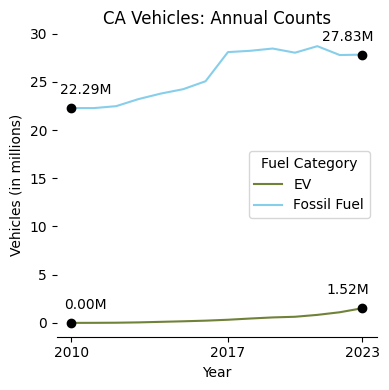

In [28]:
def yearlyVehiclesbyType(df):
    # Group the data by 'Data Year' and 'Fuel Category', summing the number of vehicles
    grouped_df = df.groupby(['Data Year', 'Fuel Category'])['Number of Vehicles'].sum().reset_index()

    # Create a new column for the year-over-year growth rate
    grouped_df['Growth Rate'] = grouped_df.groupby('Fuel Category')['Number of Vehicles'].pct_change() * 100

    plt.figure(figsize=(4, 4))

    # Create subplots: the first plot for vehicle count, the second for growth rate
    color_mapping = {
        'EV': '#708238', ## sage     
        'Fossil Fuel': '#87CEEB'## skyblue       
    }

    ## Create a line plot for each category of fuel ##
    for fuel in grouped_df['Fuel Category'].unique():
        fuel_group_df = grouped_df[grouped_df['Fuel Category'] == fuel]
        color = color_mapping.get(fuel)
        plt.plot(fuel_group_df['Data Year'], fuel_group_df['Number of Vehicles'] / 1000000, label=fuel,color = color)

        ## Annotate the first and last points ##
        first_year = fuel_group_df.iloc[0]['Data Year']
        first_value = fuel_group_df.iloc[0]['Number of Vehicles'] / 1000000
        plt.annotate(f'{first_value:.2f}M', (first_year, first_value), textcoords="offset points", xytext=(10, 10), ha='center')
        plt.plot(first_year, first_value, 'o', color='black')

        last_year = fuel_group_df.iloc[-1]['Data Year']
        last_value = fuel_group_df.iloc[-1]['Number of Vehicles'] / 1000000
        plt.annotate(f'{last_value:.2f}M', (last_year, last_value), textcoords="offset points", xytext=(-10, 10), ha='center')
        plt.plot(last_year, last_value, 'o', color='black')


    years = grouped_df['Data Year'].unique()
    first_year = years[0]
    middle_year = years[len(years) // 2]  # Calculate the middle year
    last_year = years[-1]
    plt.xticks([first_year, middle_year, last_year], [first_year, middle_year, last_year])

    plt.title('CA Vehicles: Annual Counts')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.ylabel("Vehicles (in millions)")
    plt.xlabel("Year")
    plt.legend(title='Fuel Category')
    ## Optional to save image ##
    save_img = False
    if save_img:
        plt.savefig("graphic_caliVehiclesGrowthRate.png",dpi=300)
    plt.tight_layout()
    plt.show()

yearlyVehiclesbyType(fueltype_per_countyyear_totals_df)

There seems to be a steady growth of EVs and Fossil Fuel vehicles from 2010 to 2023. But - the total number of EVs went from a 0% market share in 2010 to a ~5% market share in 2023. That confirms our suspicion that EVs are being increasingly adopted. Let's visualize the growth rate of each category of vehicles.

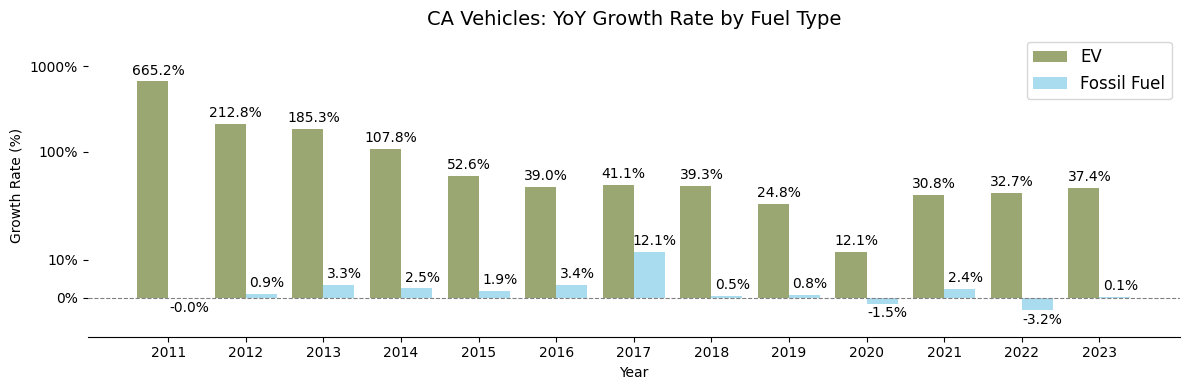

In [133]:
def percent_formatter(x, pos):
    ## function to adjust y-scaling based on percentage growth##
    return f'{int(x)}%'

def vehicleGrowthRate(df):
    ## Group the data by 'Data Year' and 'Fuel Category', summing the number of vehicles ##
    grouped_df = df.groupby(['Data Year', 'Fuel Category'])['Number of Vehicles'].sum().reset_index()

    ## Calculate the year-over-year growth rate and drop first year (.dropna) ##
    grouped_df['Growth Rate'] = grouped_df.groupby('Fuel Category')['Number of Vehicles'].pct_change() * 100
    grouped_df = grouped_df.dropna(subset=['Growth Rate'])

    ## Plotting the growth rate as an overlapped bar graph ##
    plt.figure(figsize=(12, 4))
    bar_width = 0.4

    color_mapping = {
            'EV': '#708238', ## sage     
            'Fossil Fuel': '#87CEEB'## skyblue       
        }

    ## Define x positions for the bars ##
    x = np.arange(len(grouped_df['Data Year'].unique()))
    years_with_data = grouped_df['Data Year'].unique()

    # Bar plot for growth rates with overlapping bars
    for i, fuel in enumerate(grouped_df['Fuel Category'].unique()):
        fuel_df = grouped_df[grouped_df['Fuel Category'] == fuel]

        color = color_mapping.get(fuel)

        ## Using the index to plot bars at the same x position but different colors ##
        plt.bar(x + (i * bar_width), fuel_df['Growth Rate'], width=bar_width, label=fuel, alpha=0.7, color=color)

    ## Set the x-ticks to show the years, split for number of fuel types ##
    number_of_fuel_types = len(grouped_df['Fuel Category'].unique())
    plt.xticks(x + (bar_width * (number_of_fuel_types - 1) / 2), years_with_data)

    ## Annotate the bars with the growth rates ##
    for i, fuel in enumerate(grouped_df['Fuel Category'].unique()):

        ## get df for particular fuel ##
        fuel_df = grouped_df[grouped_df['Fuel Category'] == fuel]

        ## iterate through year (x position) and position the value (percentage) at the top of the bar, offset ##
        for j, value in enumerate(fuel_df['Growth Rate']):

            ## Adjust xytext position depending on direction of bar (positive vs. negative)
            if value>=0:
                plt.annotate(f'{value:.1f}%', (x[j] + (i * bar_width), value), 
                             textcoords="offset points", xytext=(4, 5), ha='center')
            if value<0:
                plt.annotate(f'{value:.1f}%', (x[j] + (i * bar_width), value), 
                             textcoords="offset points", xytext=(4, -10), ha='center')
    ## Title and Labels ##
    plt.ylabel("Growth Rate (%)")
    plt.xlabel("Year")
    
    #plt.ylabel('Year-over-Year Growth Rate (%)',fontsize=12)
    plt.title('CA Vehicles: YoY Growth Rate by Fuel Type',fontsize=14)
    plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0 for reference

    ## Set the y-axis to a logarithmic scaling and account for presence of negative values using 'sumlog' ##
    plt.yscale('symlog',linthresh=25)

    ## Add exponential 25% buffer above the max growth rate ##
    max_growth = grouped_df['Growth Rate'].max()
    buffer_top = max_growth ** 1.2 

    ## Keep the bottom close to zero but a little lower to see negative values ##
    buffer_bottom = -(abs(grouped_df['Growth Rate'].min()) ** 2) 

    ## Set the y-limits and format them to show it as a percentage ##
    plt.ylim(buffer_bottom, buffer_top)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.legend(fontsize = 12)

    ## optional logic to save image ##
    save_img = False
    if save_img:
        plt.savefig("graphic_caliVehiclesGrowthRate.png",dpi=300)


    ## Show the plot ##
    plt.tight_layout()
    plt.show()

vehicleGrowthRate(fueltype_per_countyyear_totals_df)

EVs appear to have a stabilized year over year growth rate of ~30% whereas fossil fuel vehicles seem to have plateaued and may be trending downwards.

# California Population - Import, Cleaning

In [125]:
# cleaning up 2010-2019
df1 = pd.read_excel('./E-4_2010-2020-Internet-Version.xlsx', sheet_name= 'Table 1 County State')

,Table 1: E-4 Population Estimates for Counties and State 2011-2020 with 2010 Benchmark,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,COUNTY,4/1/2010,1/1/2011,1/1/2012,1/1/2013,1/1/2014,1/1/2015,1/1/2016,1/1/2017,1/1/2018,1/1/2019,1/1/2020,4/1/2020,Column1,Column2
1,Alameda,1510271,1527169,1549193,1575139,1597747,1622205,1641983,1656919,1666247,1675964,1681337,1682353,NaN,NaN
2,Alpine,1175,1174,1176,1180,1185,1190,1196,1201,1205,1201,1204,1204,NaN,NaN
3,Amador,38091,37089,37272,37044,37089,37453,37663,38807,39708,40227,40426,40474,NaN,NaN
4,Butte,220000,221377,222623,224391,225737,227400,228198,230412,231774,227263,216090,211632,NaN,NaN


In [44]:
mapping = {
    'Table 1: E-4 Population Estimates for Counties and State 2011-2020 with 2010 Benchmark': 'County',
    'Unnamed: 1': '2010',
    'Unnamed: 2': '2011',
    'Unnamed: 3': '2012',
    'Unnamed: 4': '2013',
    'Unnamed: 5': '2014',
    'Unnamed: 6': '2015',
    'Unnamed: 7': '2016',
    'Unnamed: 8': '2017',
    'Unnamed: 9': '2018',
    'Unnamed: 10': '2019',
    'Unnamed: 11': '2020'
}
df1.rename(columns=mapping, inplace=True)

In [45]:
df1.drop(columns=['Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14'], index=[0, 2], inplace=True)

In [46]:
df1.reset_index(drop=True, inplace=True)

In [47]:
# cleaning up 2020-2024
df2 = pd.read_excel('./E-4_2021_2024_InternetVersion (1).xlsx', sheet_name= 'Table 1 County State')


In [48]:
mapping_2 = {
    'About the Data': 'County',
    'Unnamed: 1': '2020',
    'Unnamed: 2': '2021',
    'Unnamed: 3': '2022',
    'Unnamed: 4': '2023',
    'Unnamed: 5': '2024'
}
df2.rename(columns=mapping_2, inplace=True)

In [49]:
df2.drop(columns = ['2020'], index=[0, 1, 3], inplace=True)

In [50]:
df2.reset_index(drop=True, inplace=True)

In [51]:
# merging the two
merged_pop_df = pd.merge(df1, df2, on=['County'], how='outer')
merged_pop_df.head()

,County,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Alameda,1510271,1527169,1549193,1575139,1597747,1622205,1641983,1656919,1666247,1675964,1681337,1666341,1643683,1650656,1641869
1,Amador,38091,37089,37272,37044,37089,37453,37663,38807,39708,40227,40426,40047,40010,39924,39611
2,Butte,220000,221377,222623,224391,225737,227400,228198,230412,231774,227263,216090,207403,206184,206579,205928
3,Calaveras,45578,45561,45544,45499,45461,45395,45402,45355,45367,45324,45290,45259,45021,44899,44842
4,Colusa,21419,21362,21301,21418,21442,21338,21531,21773,21808,21745,21811,21774,21722,21831,21743


In [111]:
# pivoting table
pop_df = pd.melt(merged_pop_df, id_vars=['County'], var_name='Year', value_name='Population')

pop_df['Year'] = pop_df['Year'].str.replace(":", "", regex=False)
pop_df.rename(columns={'Year': 'Data Year'}, inplace=True) 
# converting the 'Population' column to numeric 
pop_df['Population'] = pd.to_numeric(pop_df['Population'], errors='coerce')
# calculating the Z-score for the 'Population' column
pop_df['Z Score'] = zscore(pop_df['Population'])

pop_df.head()

,County,Data Year,Population,Z Score
0,Alameda,2010,1510271,0.033519
1,Amador,2010,38091,-0.251576
2,Butte,2010,220000,-0.216348
3,Calaveras,2010,45578,-0.250126
4,Colusa,2010,21419,-0.254805


In [112]:
## Operation to export as csv ##
export_population = False
if export_population:
    pop_df.to_csv('./California_Population.csv', index=False)

In [113]:
## if importing 
importcsv = False
if importcsv:
    df_pm = pd.read_csv('./California_Population.csv')
    df_vehicles = pd.read_csv('./vehicle_df')
else:
    df_vehicles = fueltype_per_countyyear_totals_df
    df_pm = pop_df

In [114]:
df_gas_vehicles = df_vehicles[df_vehicles['Fuel Category'] == 'Fossil Fuel']
df_gas_vehicles = df_gas_vehicles.rename(columns={'Number of Vehicles': 'Number of Gas Cars'})
df_gas_vehicles = df_gas_vehicles.drop(columns=['Fuel Category'])
df_gas_vehicles.head()

,Data Year,County,Number of Gas Cars
1,2010,Alameda,885402
2,2010,Alpine,1041
4,2010,Amador,30480
5,2010,Butte,133169
6,2010,Calaveras,39636


In [115]:
# seperating creating ev/gas columns so its easier to compare with pm2.5 values 
df_ev_vehicles = df_vehicles[df_vehicles['Fuel Category'] == 'EV']
df_ev_vehicles = df_ev_vehicles.rename(columns={'Number of Vehicles': 'Number of EV'})
df_ev_vehicles = df_ev_vehicles.drop(columns=['Fuel Category'])
df_ev_vehicles.head()

,Data Year,County,Number of EV
0,2010,Alameda,20
3,2010,Amador,1
8,2010,Contra Costa,10
12,2010,Fresno,2
15,2010,Humboldt,2


In [130]:
# recombining df_vehicles 
df_vehicles = pd.merge(df_gas_vehicles, df_ev_vehicles, on=['Data Year', 'County'], how='inner')
df_vehicles.head()

,Data Year,County,Number of Gas Cars,Number of EV
0,2010,Alameda,885402,20
1,2010,Amador,30480,1
2,2010,Contra Costa,666294,10
3,2010,Fresno,481145,2
4,2010,Humboldt,90949,2


In [117]:
df_pm.shape

(870, 4)

In [118]:
# strip df_pm of spaces 
df_pm['County'] = df_pm['County'].str.strip()
counties = pd.DataFrame({
    'County_df_vehicles': df_vehicles['County'],
    'County_df_pm': df_pm['County']
})
counties.head()
# Get unique counties from both DataFrames
counties_vehicles = set(df_vehicles['County'])
counties_pm = set(df_pm['County'])

# Find differences
only_in_vehicles = counties_vehicles - counties_pm
only_in_pm = counties_pm - counties_vehicles

print("Only in df_vehicles:", only_in_vehicles)
print("Only in df_pm:", only_in_pm)

# do we want to drop these values ? i will merge on left for now, 
# idk if we will need these since they don't have pm2.5 data at all. 
# we could estimate these values by comparing the counties around them that do report pm2.5 values. 

Only in df_vehicles: {'Alpine', 'Out Of State'}
Only in df_pm: {'State Total'}


In [121]:
# check shapes
df_pm.shape

(870, 4)

In [122]:
df_vehicles.shape

(775, 4)

In [123]:
# merging pm and vehicle datatables
df_pm_vehicles = pd.merge(df_pm, df_vehicles, on=['Data Year', 'County'], how='inner')
df_pm_vehicles

,County,Data Year,Population,Z Score,Number of Gas Cars,Number of EV
0,Alameda,2010,1510271,0.033519,885402,20
1,Amador,2010,38091,-0.251576,30480,1
2,Contra Costa,2010,1049025,-0.055803,666294,10
3,Fresno,2010,930450,-0.078766,481145,2
4,Humboldt,2010,134623,-0.232882,90949,2
...,...,...,...,...,...,...
747,Tulare,2023,474680,-0.167028,331744,3837
748,Tuolumne,2023,54626,-0.248374,54369,698
749,Ventura,2023,825960,-0.099001,651851,31980
750,Yolo,2023,220454,-0.216260,152560,6757


In [74]:
## Optional Import
pm2_5vehicleimport = False

if pm2_5vehicleimport:
    df_pm_vehicles.to_csv('/Users/clarissaclark/SIADS_Milestone_1/PM2.5_Vehicles.csv', index=False)

In [126]:
# clean df_pop county column to match df_pm_vehicle county column 
df_pop = pop_df
df_pop['County'] = df_pop['County'].str.strip()
df_pop['County'] = df_pop['County'].str.title()
df_pop['County'] = df_pop['County'].str.replace(r'\s+', ' ', regex=True) 

In [127]:
# Get unique counties from both DataFrames
counties_pop = set(df_pop['County'])
counties_pm_vehicles = set(df_pm_vehicles['County'])

# Find differences
only_in_pop = counties_pop - counties_pm_vehicles
only_in_pm_vehicles = counties_pm_vehicles - counties_pop

print("Only in df_pop:", only_in_pop)
print("Only in df_pm_vehicles:", only_in_pm_vehicles)
# for now, we will merge on left for df_pm_vehicles 

Only in df_pop: {'State Total'}
Only in df_pm_vehicles: set()


In [128]:
df_pm_vehicles_pop= pd.merge(df_pm_vehicles, df_pop, on=['County', 'Data Year'], how='inner')
df_pm_vehicles_pop.rename(columns={'Z Score_x':'Total Population Z Score'}, inplace=True)
df_pm_vehicles_pop.rename(columns={'Population_x':'Total Population'}, inplace=True)
df_pm_vehicles_pop

,County,Data Year,Total Population,Total Population Z Score,Number of Gas Cars,Number of EV,Population_y,Z Score_y
0,Alameda,2010,1510271,0.033519,885402,20,1510271,0.033519
1,Amador,2010,38091,-0.251576,30480,1,38091,-0.251576
2,Contra Costa,2010,1049025,-0.055803,666294,10,1049025,-0.055803
3,Fresno,2010,930450,-0.078766,481145,2,930450,-0.078766
4,Humboldt,2010,134623,-0.232882,90949,2,134623,-0.232882
...,...,...,...,...,...,...,...,...
747,Tulare,2023,474680,-0.167028,331744,3837,474680,-0.167028
748,Tuolumne,2023,54626,-0.248374,54369,698,54626,-0.248374
749,Ventura,2023,825960,-0.099001,651851,31980,825960,-0.099001
750,Yolo,2023,220454,-0.216260,152560,6757,220454,-0.216260


In [131]:
# to csv 
tocsv = False
if tocsv:
    df_pm_vehicles_pop.to_csv('PM2.5_Vehicles_Population.csv', index=False)